## Reproducing Fig. 3 of K01 at z=0

Kepert est défini en storm-relative. Cependant dans son modèle le cyclone se propage dans le sens des x positifs, soit vers la droite. Mais sur ces figures il affiche un cyclone qui se propage vers l'ouest. Il suffit de faire une rotation de 180 degres du champ de vents. Ce sont les vents en storm-relative par contre. Je peux changer cela dans la fonction kepert2001().

Be careful, my storm is going to the right, while Kepert's storm is going to the left. So I rotate the matplotlib figures by 180°.

Be careful, the Holland profile used by Kepert has been slighlty modified (because they had problems to apply in their numerical simulations). The details are given in the Part II paper. That's why I don't have exatcly the same results;

Try to change Utu and Utv = 0 or not in the functions (0 by default);

In [5]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Statistics
from sklearn import linear_model, neighbors

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [25]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / abs(K * ((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * eta(Rs, Vs, K, C, fcor) + 3j * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * psi(Rs, Vs, K, C, fcor) + 3j * eta(Rs, Vs, K, C, fcor)]
    return num / den

def A1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 + 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 - 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 - 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 + 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

# Radial and tangential wind components at the surface (z = 0)
def u0(Rs, Vs, K, C, fcor):
    '''At the surface (z = 0)'''
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor):
    '''At the surface (z = 0)'''
    v0 = np.imag(A0(Rs, Vs, K, C, fcor))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(1j * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(-1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(-1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(-1j * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(-1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    return u_1(THs, Rs, Vs, Ut, K, C, fcor) + u0(Rs, Vs, K, C, fcor) + u1(THs, Rs, Vs, Ut, K, C, fcor)

def v_BL(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    return Vs + v_1(THs, Rs, Vs, Ut, K, C, fcor) + v0(Rs, Vs, K, C, fcor) + v1(THs, Rs, Vs, Ut, K, C, fcor)

# FINAL MODEL
def kepert2001(THs, Rs, Vs, Ut, K, C, fcor):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, Ut, K, C, fcor)
    v_K01   = v_BL(THs, Rs, Vs, Ut, K, C, fcor)  

    # # Adds the translation speed
    # Utu     = Ut * np.cos(THs) # Radial component of Ut
    # Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    Utu = Utv = 0
    
    return u_K01 + Utu, v_K01 + Utv

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, valid_radii):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model
    u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)

    # Compute asymmetries on Kepert wind field
    aks         = []
    # Iterate over all radii
    for rad in tqdm(valid_radii): # Iterate only in the valid range to optimize time
        ak, _, _  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
        aks.append(ak)
    
    return aks, kep_pol

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette      = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [26]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

In [72]:
### Parameters of Fig. 3 in Kepert 2001
lat  = 15.
B    = 1.3
Vmin = 0
Rmax = 40000
Vmax = 40
Ut   = 5

V    = holland_profile(rs, lat, B, Vmin, Rmax, Vmax)
Vs   = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

C    = 2e-3
K    = 50

fcr  = coriolis(lat)

# plt.plot(rs, V)
# plt.grid()

In [73]:
u_K01, v_K01 = kepert2001(THs, Rs, Vs, Ut, K, C, fcr) # Takes 3-4 seconds
print('Kepert model applied')

Kepert model applied


In [74]:
kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)
print('Polar dataset obtained')

Polar dataset obtained


In [75]:
kep_car      = get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol)
print('Cartesian dataset obtained.')

Cartesian dataset obtained.


### Check inflow angle

/tmp/ipykernel_4463/2651675828.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  abs(kep_car.inflow_angle).plot(vmin=0, vmax=45, cmap=cm.get_cmap('rainbow', 9))


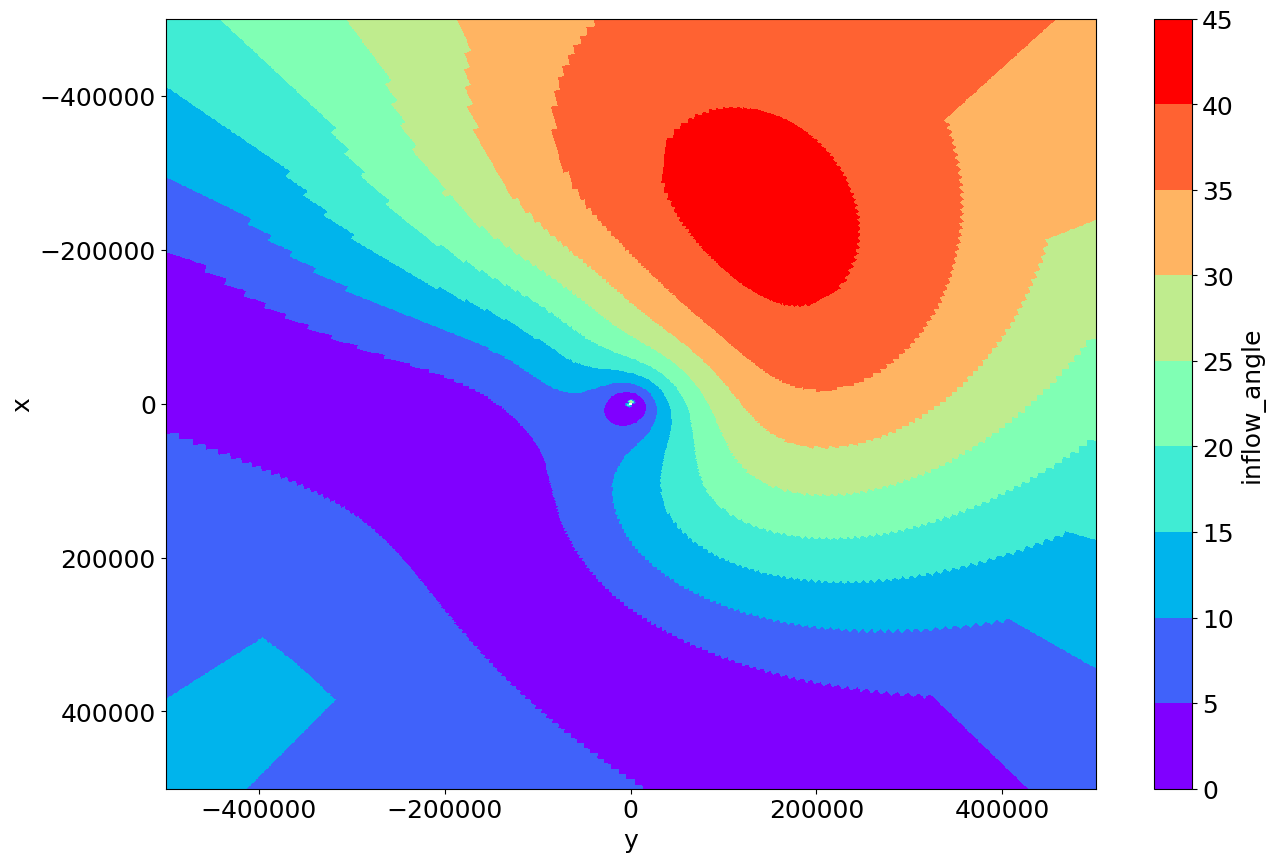

In [87]:
# Tamizi 2020 Fig. 16
abs(kep_car.inflow_angle).plot(vmin=0, vmax=45, cmap=cm.get_cmap('rainbow', 9))
plt.gca().invert_yaxis()

### Check Kepert at the surface (z = 0)

/tmp/ipykernel_4463/1618116860.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


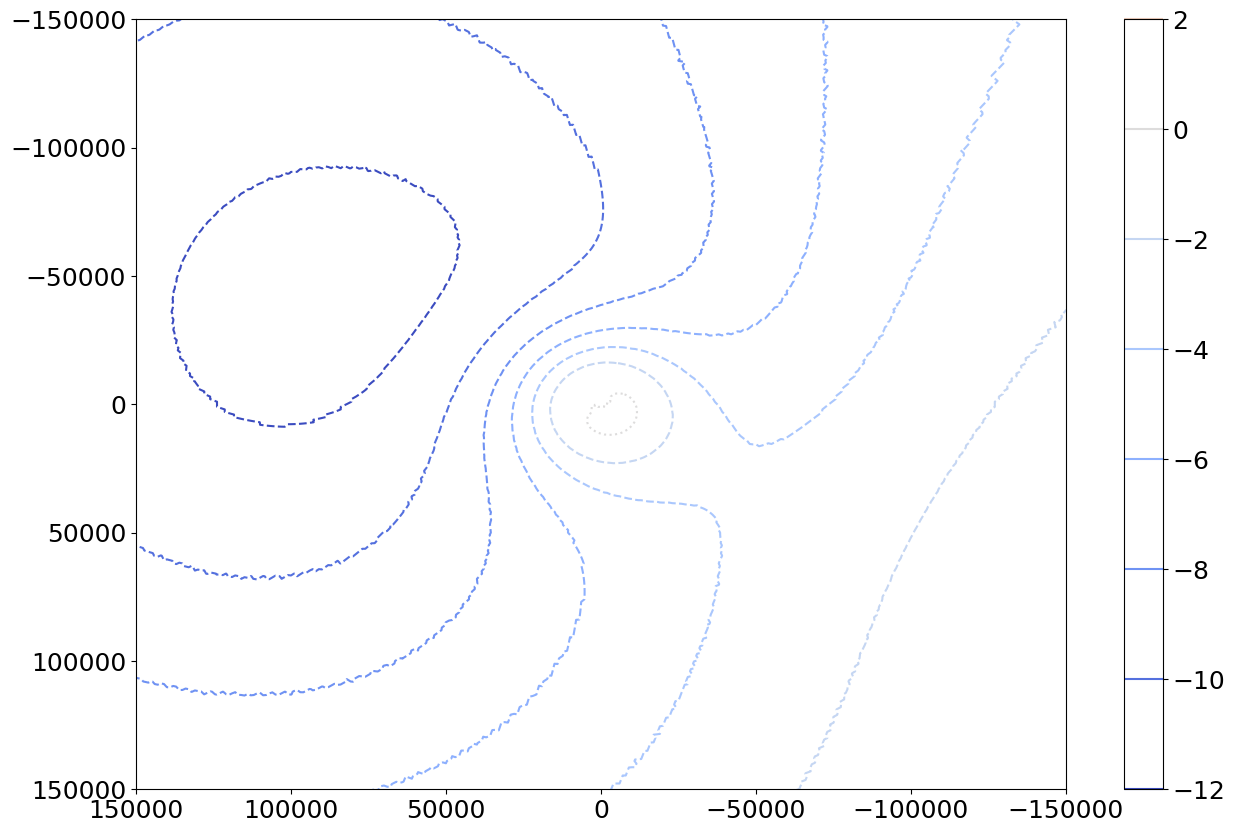

In [134]:
# 5th column (storm-relative radial flow)

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.rad_wind), levels=[-12, -10, -8, -6, -4, -2, 0, 2], vmin=-12, vmax=12, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_4463/268215940.py:7: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


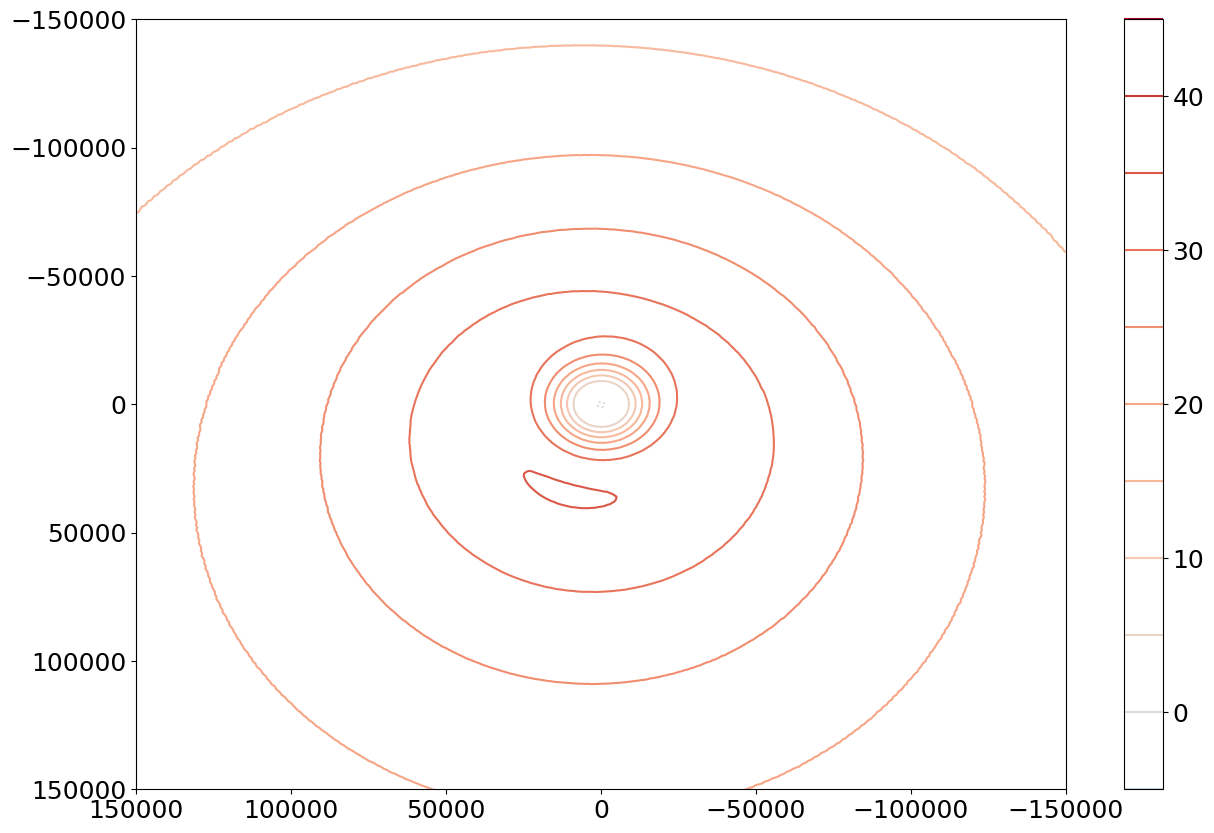

In [136]:
# 6th column (storm-relative azimuthal flow)

cntr = plt.contour(x_ref, y_ref, np.array(kep_car.tan_wind), levels=[-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45], vmin=-45, vmax=45, cmap='coolwarm')


# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [98]:
def get_asymmetric_components_kepert2001(THs, Rs, Vs, Ut, K, C, fcor):
    u_1_K01 = u_1(THs, Rs, Vs, Ut, K, C, fcor)
    v_1_K01 = v_1(THs, Rs, Vs, Ut, K, C, fcor)
    u1_K01  = u1(THs, Rs, Vs, Ut, K, C, fcor)
    v1_K01  = v1(THs, Rs, Vs, Ut, K, C, fcor)
    return u_1_K01, v_1_K01, u1_K01, v1_K01

u_1_K01, v_1_K01, u1_K01, v1_K01 = get_asymmetric_components_kepert2001(THs, Rs, Vs, Ut, K, C, fcr)

a_pol = xr.Dataset(
    data_vars={
        'u_1': (('theta', 'rad'), u_1_K01),
        'v_1': (('theta', 'rad'), v_1_K01),
        'u1':  (('theta', 'rad'), u1_K01),
        'v1':  (('theta', 'rad'), v1_K01),
    },
    coords={
        'theta': np.rad2deg(ths),
        'rad': rs,
    }
)

a_car = xr.Dataset(
    data_vars={
        'u_1': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u_1).flatten(), (x_ref, y_ref), method='nearest')),
        'v_1': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v_1).flatten(), (x_ref, y_ref), method='nearest')),
        'u1':  (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u1).flatten(),  (x_ref, y_ref), method='nearest')),
        'v1':  (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v1).flatten(),  (x_ref, y_ref), method='nearest')),
    },
    coords={
        'x': dim_ref,
        'y': dim_ref,
    }
)

/tmp/ipykernel_4463/2173723858.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


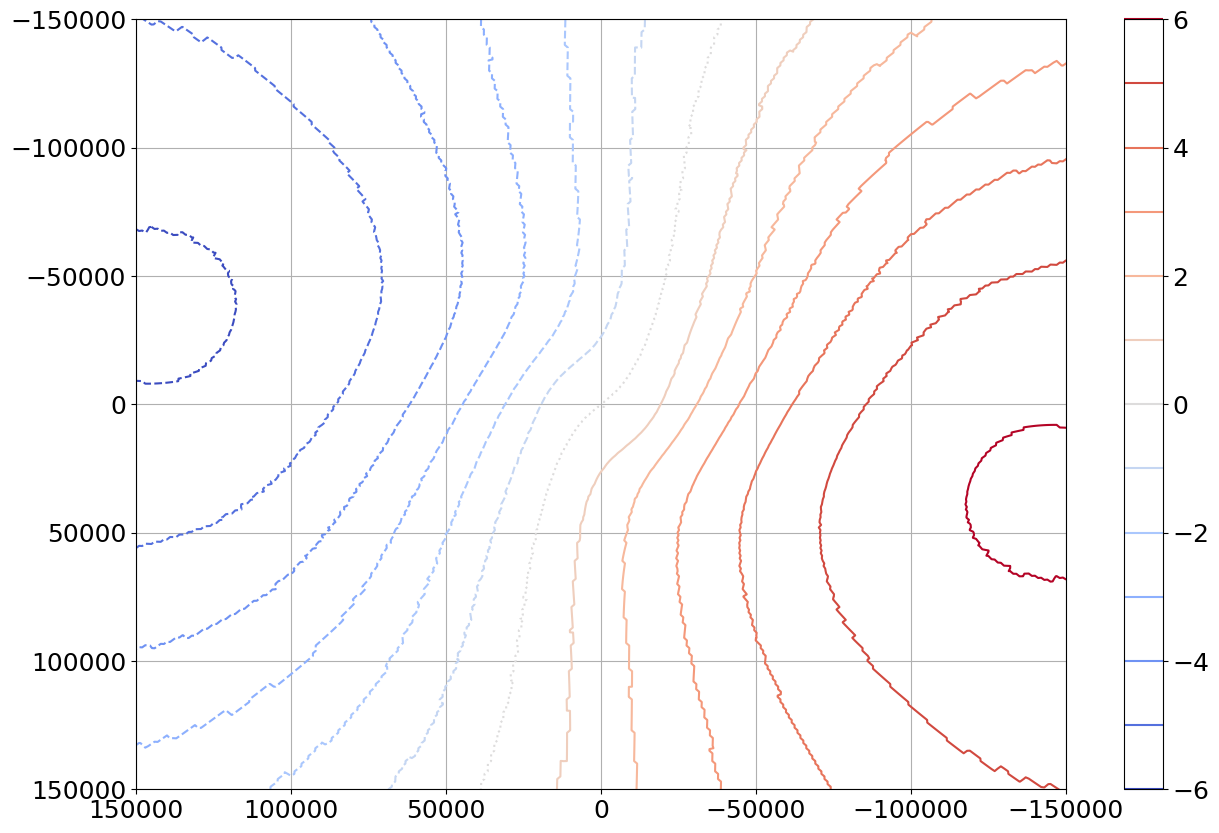

In [127]:
# 1st column (u-1)

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u_1), levels=[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_4463/3060579462.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


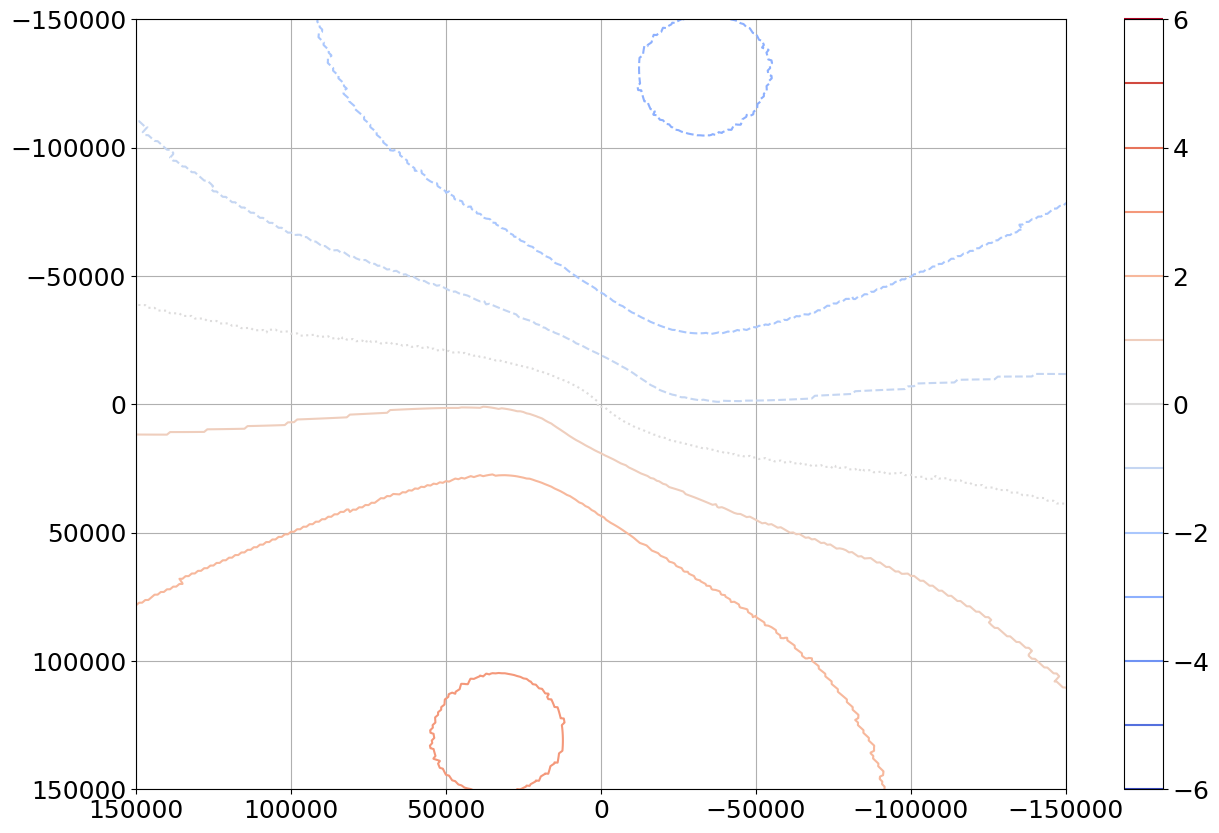

In [128]:
# 2nd column (v-1)

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v_1), levels=[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_4463/2057712401.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


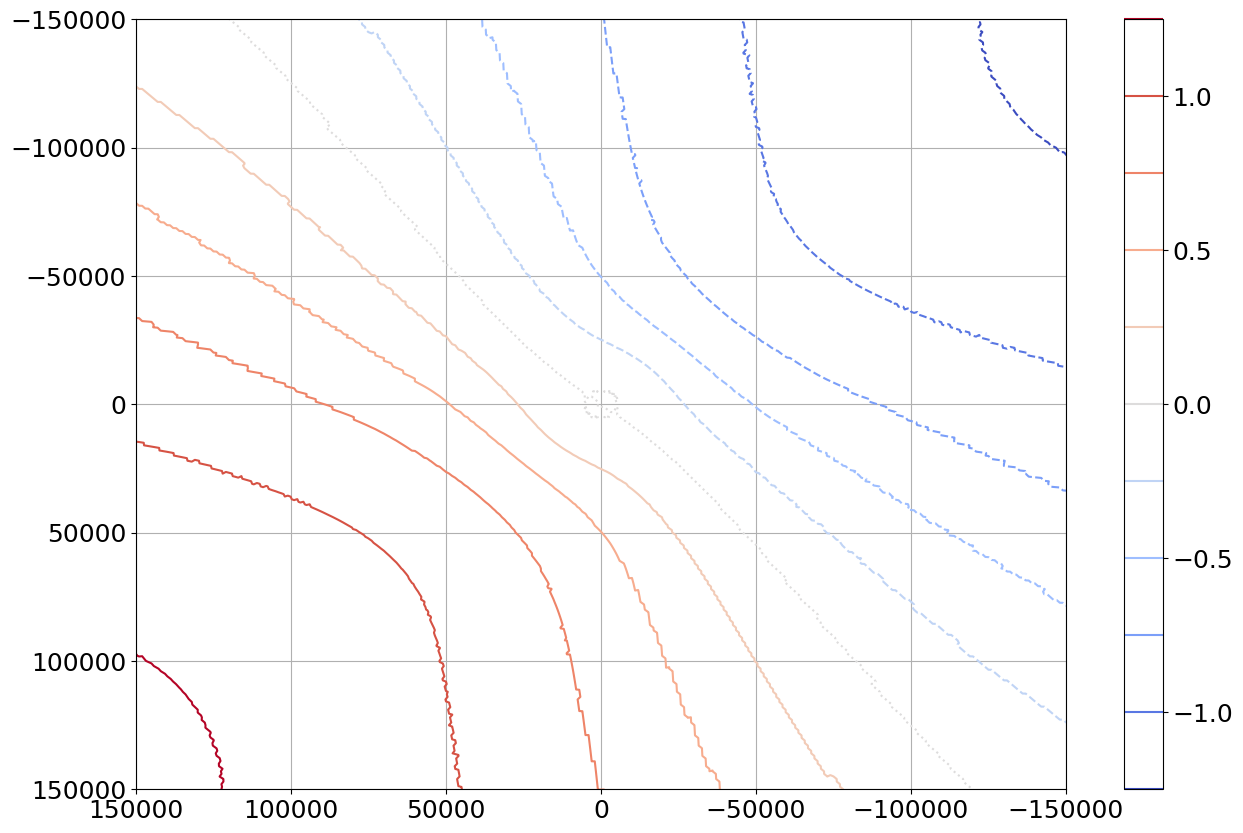

In [130]:
# 3rd column (u1)

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u1), levels=[-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25],  vmin=-1.25, vmax=1.25, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_4463/2407663930.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


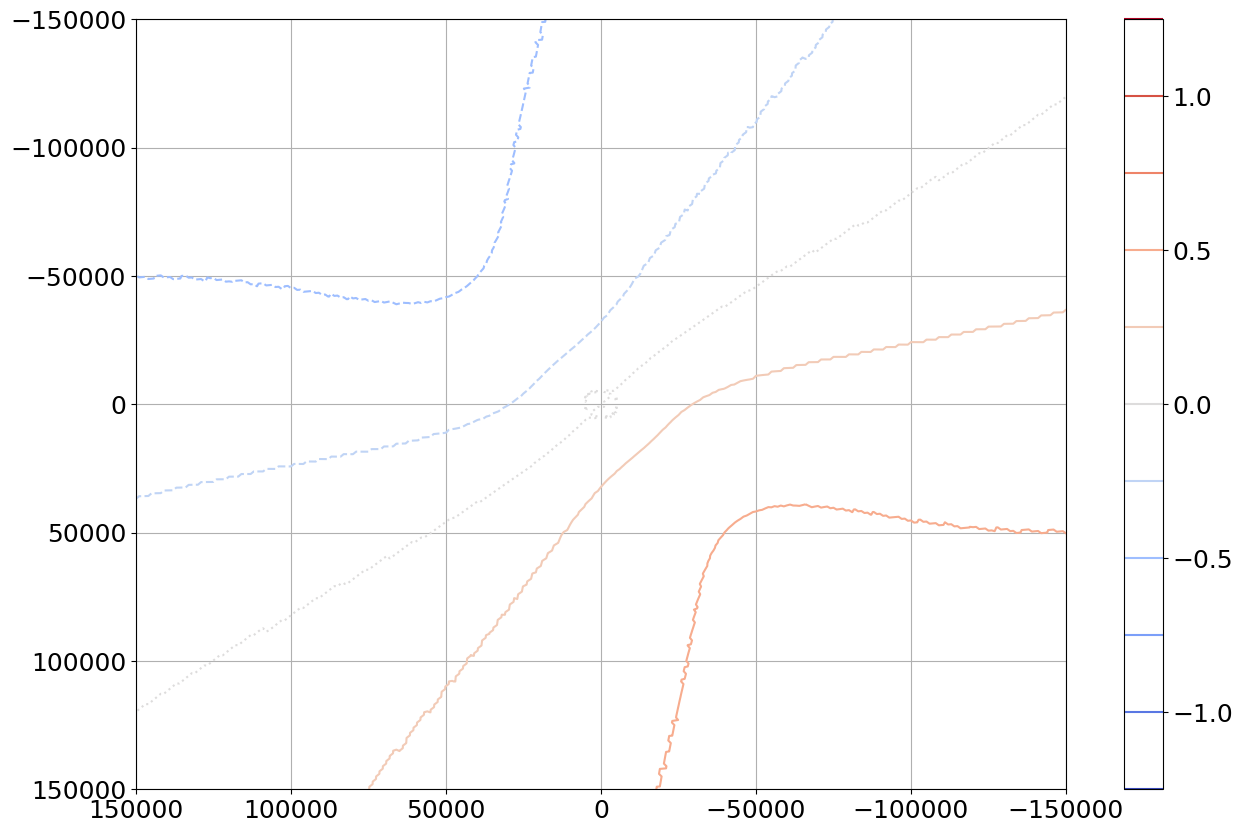

In [132]:
# 4th column (v1)

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v1), levels=[-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25], vmin=-1.25, vmax=1.25, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [137]:
### Own checks
def get_symmetric_components_kepert2001(Rs, Vs, K, C, fcor):
    u0_K01 = u0(Rs, Vs, K, C, fcor)
    v0_K01 = v0(Rs, Vs, K, C, fcor)
    return u0_K01, v0_K01

u0_K01, v0_K01 = get_symmetric_components_kepert2001(Rs, Vs, K, C, fcr)

a_pol = xr.Dataset(
    data_vars={
        'u0': (('theta', 'rad'), u0_K01),
        'v0': (('theta', 'rad'), v0_K01),
    },
    coords={
        'theta': np.rad2deg(ths),
        'rad': rs,
    }
)

a_car = xr.Dataset(
    data_vars={
        'u0': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.u0).flatten(), (x_ref, y_ref), method='nearest')),
        'v0': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(a_pol.v0).flatten(), (x_ref, y_ref), method='nearest')),
    },
    coords={
        'x': dim_ref,
        'y': dim_ref,
    }
)

/tmp/ipykernel_4463/513060175.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


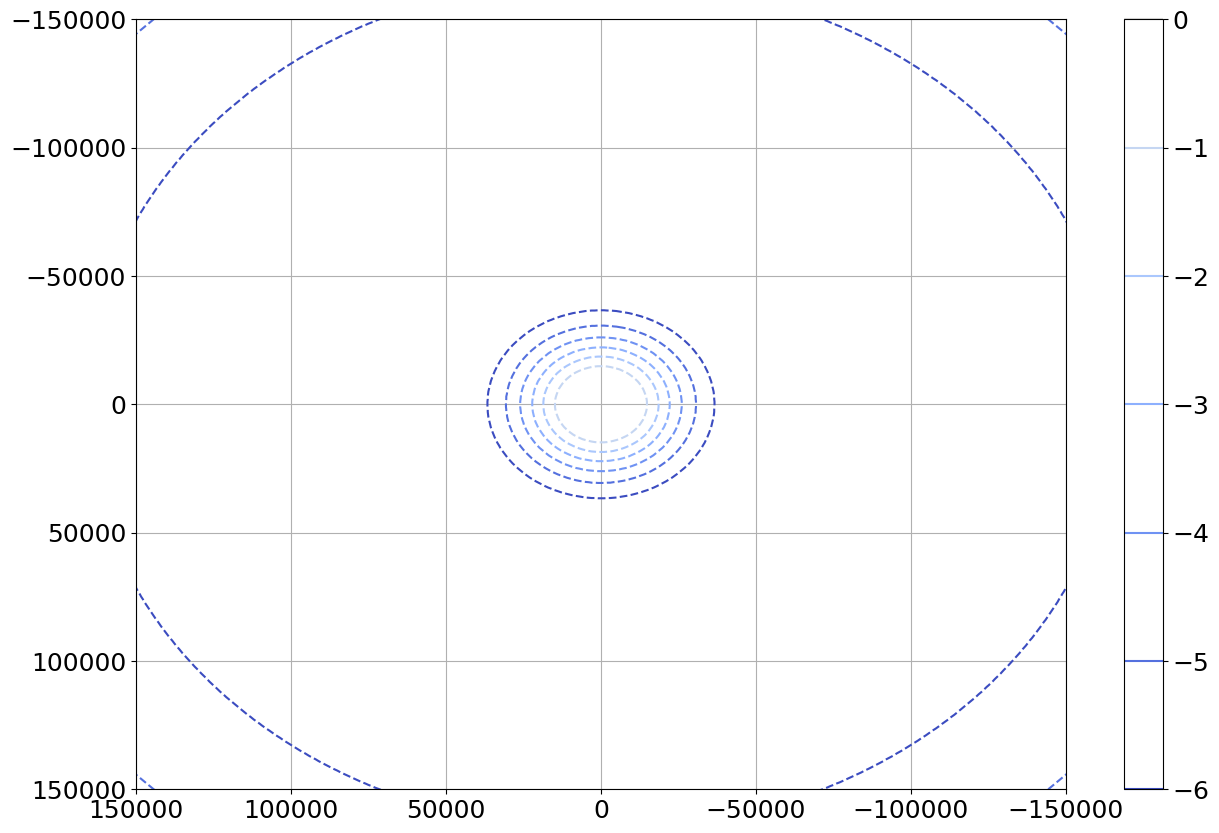

In [143]:
# Custom (u0)

cntr = plt.contour(x_ref, y_ref, np.array(a_car.u0), levels=[-6, -5, -4, -3, -2, -1, 0], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

/tmp/ipykernel_4463/3887339507.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for line, lvl in zip(cntr.collections, cntr.levels):


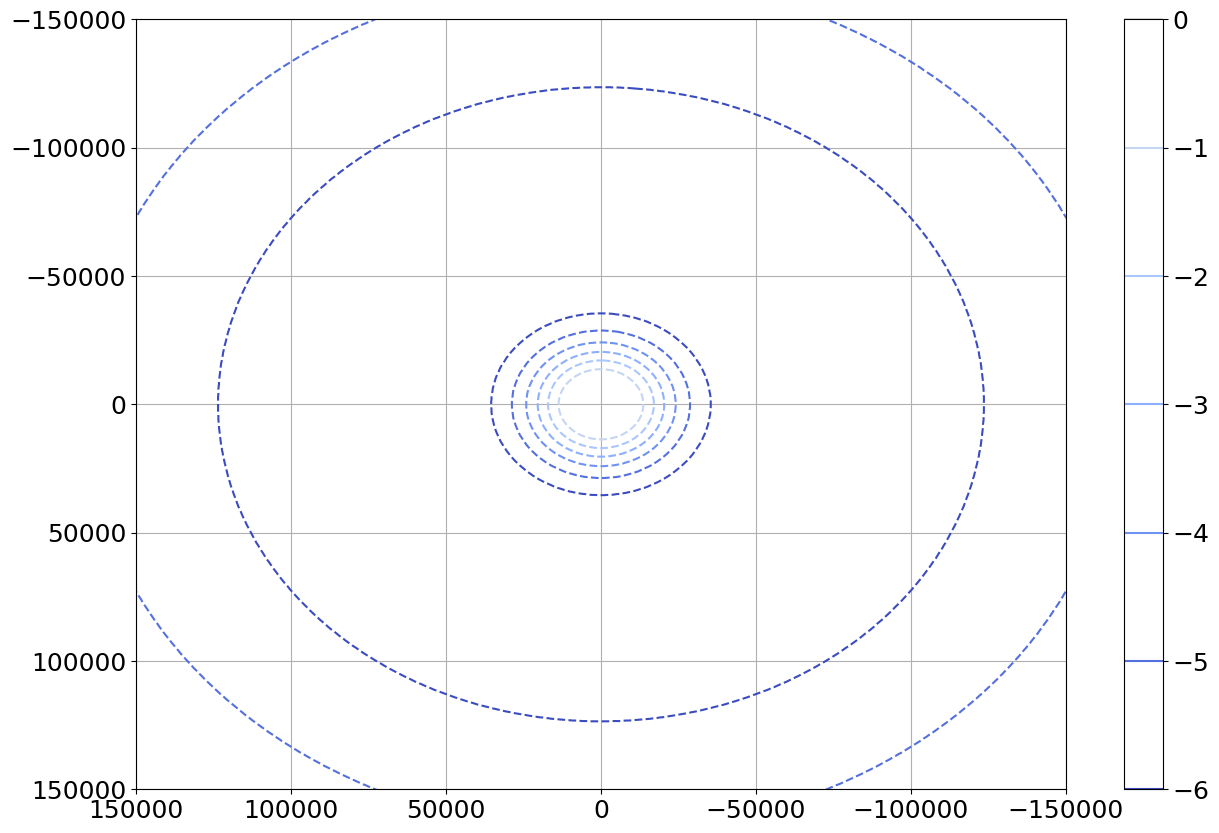

In [146]:
# Custom (v0)

cntr = plt.contour(x_ref, y_ref, np.array(a_car.v0), levels=[-6, -5, -4, -3, -2, -1, 0], vmin=-6, vmax=6, cmap='coolwarm')

# Override the linestyles based on the levels.
for line, lvl in zip(cntr.collections, cntr.levels):
    if lvl < 0:
        line.set_linestyle('--')
    elif lvl == 0:
        line.set_linestyle(':')
    else:
        line.set_linestyle('-')

# Grid
plt.colorbar()
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)
plt.grid()

# Pour se ramener à Kepert on tourne a figure de 180° (pas très élégant comme solution mais bon):
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [17]:
xs  = np.linspace(10000, 250000, 240)[::10]
aks = []
for rad in tqdm(xs): # Iterate only in the valid range to optimize time
    ak, _, _  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
    aks.append(ak)

  0%|          | 0/24 [00:00<?, ?it/s]

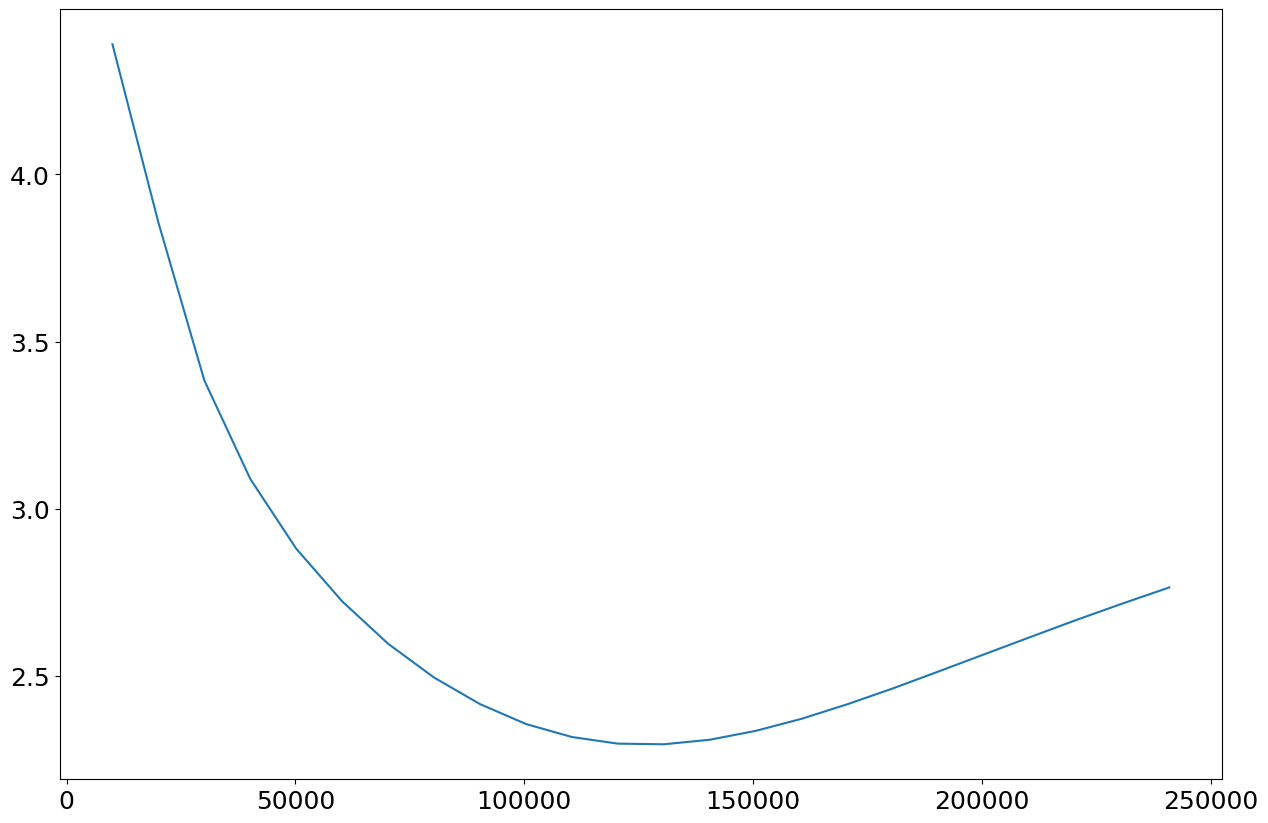

In [18]:
plt.plot(xs, aks)

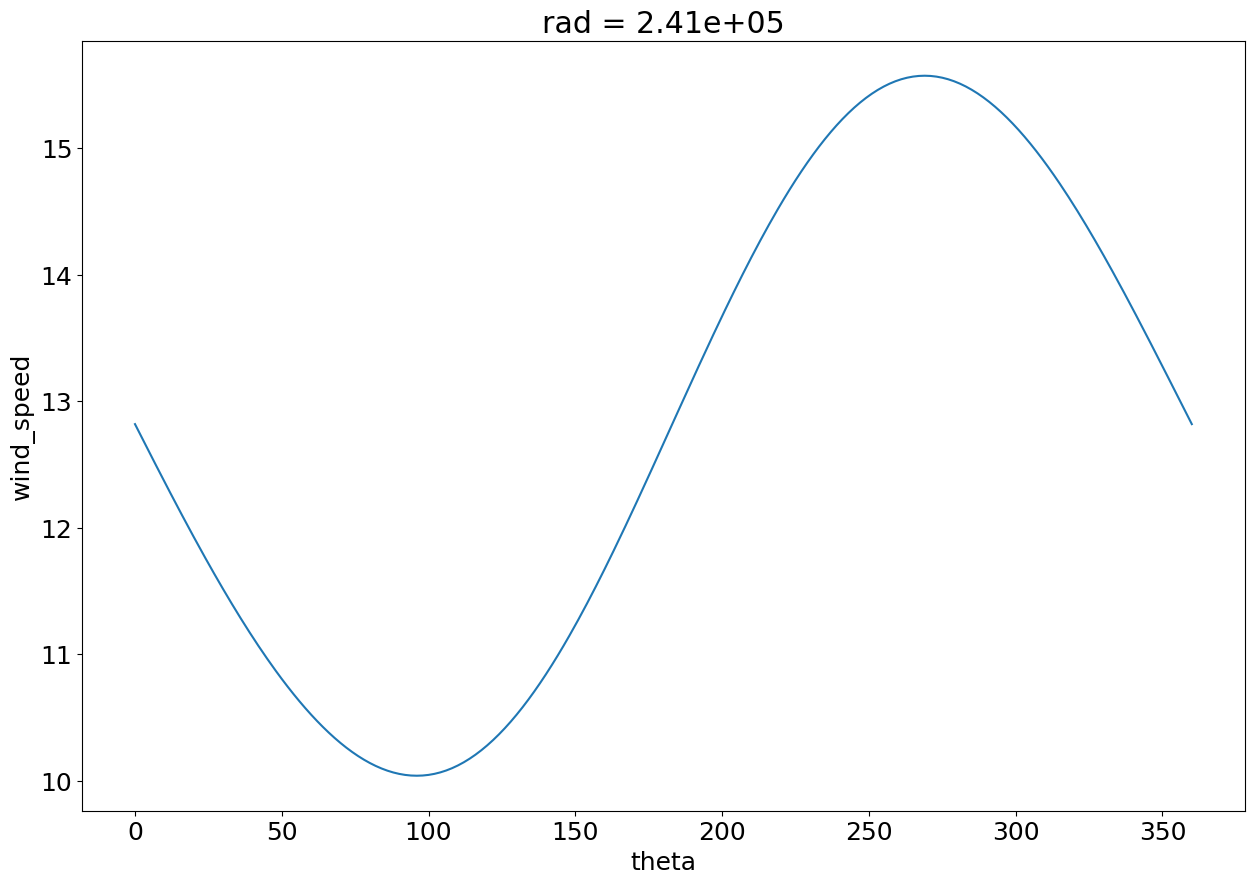

In [20]:
kep_pol.wind_speed.sel(rad=rad, method='nearest').plot()